# Geospatial Visualization

This notebook aims to visualize the geospatial information in the project such as the number of orders by regions based on the list of merchants willing to onboard with the firm.

<div class="alert alert-block alert-warning">
<b>Note:</b> If you wish to reproduce the plot, make sure to run the script and produce all required curated datasets first, then download the shapefile data from the link below and extract the "SA2_2021_AUST_SHP_GDA2020" folder to data/tables directory, before running this notebook.
</div>

Shapefile download link: [https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA2_2021_AUST_SHP_GDA2020.zip](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA2_2021_AUST_SHP_GDA2020.zip)

In [20]:
# useful imports
import pandas as pd
import numpy as np
import os
import re
import geopandas as gpd
import io
import requests

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [30]:
# Read ABS SA2 shapefile
sf = gpd.read_file("../data/tables/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sf = sf[['SA2_CODE21','geometry']][:-1]
sf['SA2_CODE21'] = pd.to_numeric(sf['SA2_CODE21'])

# Read merchant joined consumer dataset
merchant_consumer = spark.read.parquet("../data/curated/merchant_consumers")

# Read consumer dataset
consumer_region = spark.read.parquet("../data/curated/consumer_regions")

# Read ABS postcode data
abs_postcode = pd.read_csv("../data/tables/POA/AUS/2021Census_G01_AUST_POA.csv")
                                     
# Read SA2 longitude, latitude dataset
url = "https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv"
s = requests.get(url).content
sa2_df = pd.read_csv(io.StringIO(s.decode('utf-8')))
sa2_df = sa2_df[['postcode', 'SA2_MAINCODE_2016', 'Long_precise', 'Lat_precise']]
sa2_df = (sa2_df.groupby(['SA2_MAINCODE_2016'], as_index=False)['Lat_precise','Long_precise'].mean())
sa2_df.rename({'SA2_MAINCODE_2016':'sa2_code'}, axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [31]:
# Join merchant data to customer data
merchant_join_consumer = merchant_consumer.join(consumer_region, 'user_id')

# Find SA2 regions orders
sa2_orders = merchant_join_consumer.groupby('sa2_code').agg(F.sum('num_order_id').alias('total_orders')).toPandas()

In [38]:
# Join SA2_orders to the SA2 latitude, longitude dataset
order_map_df = sa2_df.merge(sa2_orders, on='sa2_code')

# Convert the resulting data into geopandas dataframe
gdf = gpd.GeoDataFrame(
      order_map_df, geometry=gpd.points_from_xy(order_map_df.Long_precise, order_map_df.Lat_precise))

# Merge resulting gdf to shapefile
gdf = sf.merge(sa2_orders, right_on='sa2_code', left_on='SA2_CODE21')

In [39]:
gdf

,SA2_CODE21,geometry,sa2_code,total_orders
0,101021007,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",101021007,216474
1,101021008,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3...",101021008,5764
2,101021009,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",101021009,17292
3,101021010,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",101021010,28820
4,101021012,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3...",101021012,16686
...,...,...,...,...
2082,801111141,"POLYGON ((148.80407 -35.37619, 148.80417 -35.3...",801111141,9227
2083,901011001,"POLYGON ((105.67393 -10.41566, 105.67399 -10.4...",901011001,3479
2084,901021002,"MULTIPOLYGON (((96.91512 -12.14044, 96.91513 -...",901021002,10358
2085,901031003,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556...",901031003,11560


# Number of Orders by Regions From All Merchants

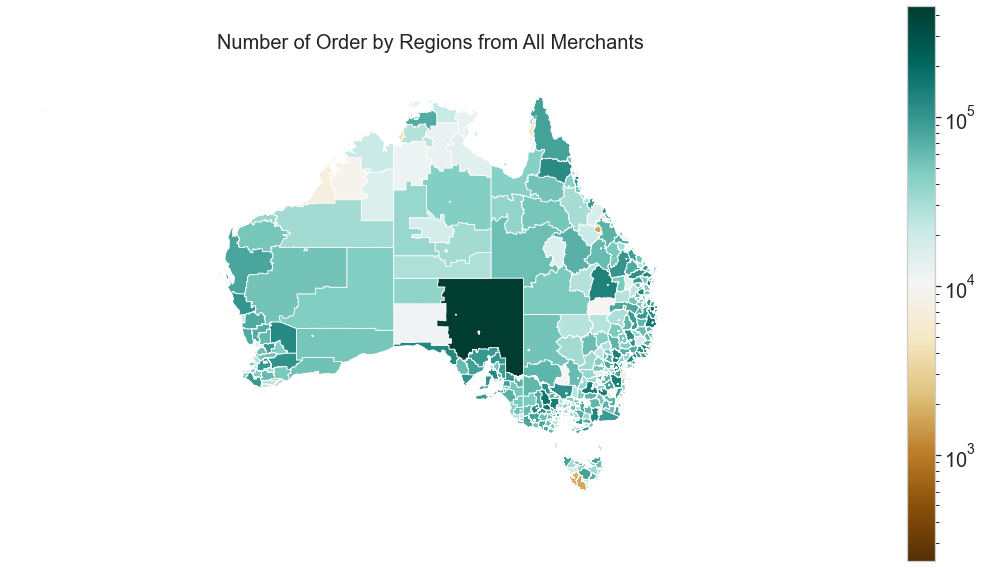

In [60]:
# Plot number of orders by region from all merchants
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(15, 8))

ax = gdf.plot(column='total_orders', linewidth=0.8, cmap="BrBG",edgecolor='white', ax=ax, norm=matplotlib.colors.LogNorm(vmin=gdf['total_orders'].min(), vmax=gdf['total_orders'].max()), legend=True)

# remove the axis
fig = ax.figure
cb_ax = fig.axes[1] 
ax.axis('off')
cb_ax.tick_params(labelsize=20)

# add a title
ax.set_title('Number of Order by Regions from All Merchants', fontdict={'fontsize': '20', 'fontweight' : '3'})

fig.tight_layout()

#saving our map as .png file.
fig.savefig('../plots/orders_by_regions.png', dpi=300, transparent=True)


# Number of Orders by Regions From Top 100 Merchants

In [54]:
# Get top 100 merchants' abn
top_100 = pd.read_csv("../data/top-100.csv")
top_100 = top_100['merchant_abn'].unique().tolist()

# Filter merchant_consumer to the top 100 merchants
merchant_join_consumer = merchant_join_consumer.filter(F.col('merchant_abn').isin(top_100))


In [56]:
# Repeat previous steps
sa2_orders = merchant_join_consumer.groupby('sa2_code').agg(F.sum('num_order_id').alias('total_orders')).toPandas()
order_map_df = sa2_df.merge(sa2_orders, on='sa2_code')
gdf = gpd.GeoDataFrame(
      order_map_df, geometry=gpd.points_from_xy(order_map_df.Long_precise, order_map_df.Lat_precise))
gdf = sf.merge(sa2_orders, right_on='sa2_code', left_on='SA2_CODE21')

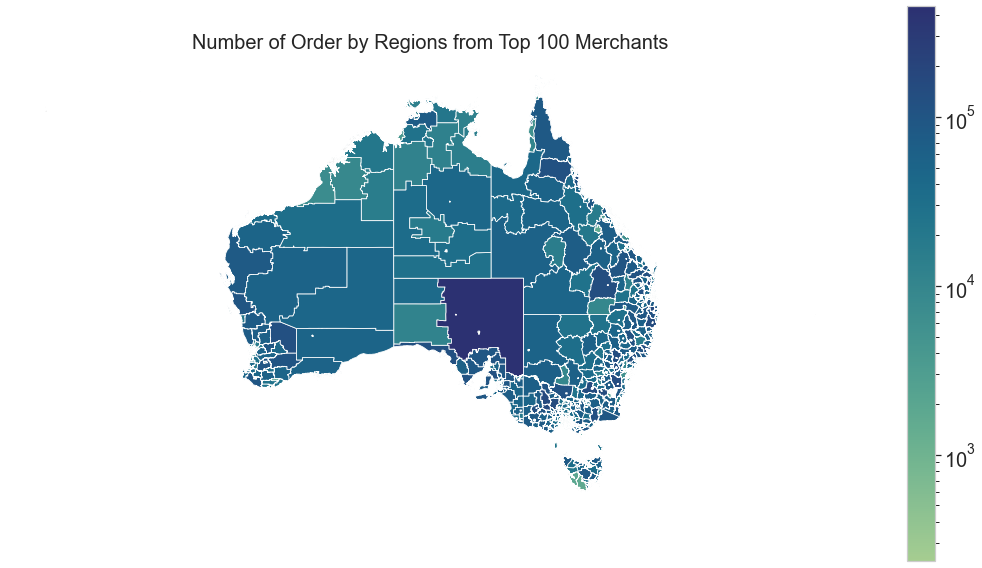

In [61]:
# Plot number of orders by region from top 100 merchants
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(15, 8))

ax = gdf.plot(column='total_orders', linewidth=0.8, cmap="crest",edgecolor='white', ax=ax, norm=matplotlib.colors.LogNorm(vmin=gdf['total_orders'].min(), vmax=gdf['total_orders'].max()), legend=True)

# remove the axis
fig = ax.figure
cb_ax = fig.axes[1] 
ax.axis('off')
cb_ax.tick_params(labelsize=20)

# add a title
ax.set_title('Number of Order by Regions from Top 100 Merchants', fontdict={'fontsize': '20', 'fontweight' : '3'})

fig.tight_layout()

#saving our map as .png file.
fig.savefig('../plots/orders_by_regions_top_100.png', dpi=300, transparent=True)